## Overview

This Jupyter notebook focuses on predicting next-day rain by training classification models on the target variable `RainTomorrow`. The goal is to determine whether it will rain the next day, with the target variable indicating "Yes" if the rainfall is 1mm or more, and "No" otherwise. This will follow these general steps:

1. Explore the dataset to understand its structure, features, and distributions.
2. Handle missing values, encode categorical variables, and perform any necessary data transformations.
3. Select relevant features for model training.
4. Train a classification model on the historical data to predict "RainTomorrow".
5. Evaluate the model using metrics to assess the model performance.
6. Summarize findings and discuss the predictive capability of the models.

## Dataset Information

The dataset used in this analysis contains approximately 10 years of daily weather observations from various locations across Australia, obtained from https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package and covers a comprehensive range of weather observations.


### Importing the libraries and the Dataset


In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score , jaccard_score , f1_score , log_loss , confusion_matrix, classification_report
import sklearn.metrics as metrics

In [37]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Data Exploration and Preprocessing


In [38]:
df.shape

(145460, 23)

In [39]:
#View summary of dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [40]:
#Explore target varible 'RainTomorrow'
print("number of missing data:", df['RainTomorrow'].isnull().sum())
print("number of unique values:", df['RainTomorrow'].nunique())
print("unique values:", df['RainTomorrow'].unique())
value_counts = df['RainTomorrow'].value_counts()
percentage_counts = df['RainTomorrow'].value_counts(normalize=True) * 100
print("Frequency of these values (with percentage):")
print(pd.DataFrame({'Counts': value_counts, 'Percentage': percentage_counts}))

number of missing data: 3267
number of unique values: 2
unique values: ['No' 'Yes' nan]
Frequency of these values (with percentage):
     Counts  Percentage
No   110316   77.581878
Yes   31877   22.418122


In [41]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.drop('Date',axis=1,inplace=True)

#### Numerical and Categorical Features

In [42]:
# Identify Numerical and Categorical Features

numerical_columns = df.select_dtypes(include=['number']).columns
numerical_variables = numerical_columns.tolist()
print("Numerical Features Count:", len(numerical_variables))
print("Numerical Features:", numerical_variables)

categorical_columns = df.select_dtypes(include=['object']).columns
categorical_variables = categorical_columns.tolist()
print("Categorical Features Count:", len(categorical_variables))
print("Categorical Features:", categorical_variables)


Numerical Features Count: 19
Numerical Features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Day', 'Month', 'Year']
Categorical Features Count: 6
Categorical Features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [43]:
#View statistical properties of categorical variables
categorical_summary = df[categorical_columns].describe()
print(categorical_summary)

        Location WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
count     145460      135134     134894     141232    142199       142193
unique        49          16         16         16         2            2
top     Canberra           W          N         SE        No           No
freq        3436        9915      11758      10838    110319       110316


In [44]:
# Missing values in categorical variables
for col in categorical_columns:
    missing_count = df[col].isnull().sum()
    missing_percentage = (missing_count / len(df[col])) * 100
    print(f"{col}: {missing_count} missing values ({missing_percentage:.2f}%)")

Location: 0 missing values (0.00%)
WindGustDir: 10326 missing values (7.10%)
WindDir9am: 10566 missing values (7.26%)
WindDir3pm: 4228 missing values (2.91%)
RainToday: 3261 missing values (2.24%)
RainTomorrow: 3267 missing values (2.25%)


In [45]:
# Drop rows with missing values in the target variable
df.dropna(subset=['RainTomorrow'], inplace=True)

# Fill missing values with mode for the rest of categorical variables
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify that missing values are filled
print("Number of missing values after filling:")
print(df[categorical_columns].isnull().sum())

Number of missing values after filling:
Location        0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64


In [46]:
#View statistical properties of numerical variables
numerical_summary = df[numerical_columns].describe()
print(numerical_summary)

             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000      31.000000       7.0000

In [47]:
# Missing values in numerical variables
for col in numerical_columns:
    missing_count = df[col].isnull().sum()
    missing_percentage = (missing_count / len(df[col])) * 100
    print(f"{col}: {missing_count} missing values ({missing_percentage:.2f}%)")

MinTemp: 637 missing values (0.45%)
MaxTemp: 322 missing values (0.23%)
Rainfall: 1406 missing values (0.99%)
Evaporation: 60843 missing values (42.79%)
Sunshine: 67816 missing values (47.69%)
WindGustSpeed: 9270 missing values (6.52%)
WindSpeed9am: 1348 missing values (0.95%)
WindSpeed3pm: 2630 missing values (1.85%)
Humidity9am: 1774 missing values (1.25%)
Humidity3pm: 3610 missing values (2.54%)
Pressure9am: 14014 missing values (9.86%)
Pressure3pm: 13981 missing values (9.83%)
Cloud9am: 53657 missing values (37.74%)
Cloud3pm: 57094 missing values (40.15%)
Temp9am: 904 missing values (0.64%)
Temp3pm: 2726 missing values (1.92%)
Day: 0 missing values (0.00%)
Month: 0 missing values (0.00%)
Year: 0 missing values (0.00%)


In [48]:
# Fill missing values with median for numerical variables
for col in numerical_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Verify that missing values are filled
print("Number of missing values after filling:")
print(df[numerical_columns].isnull().sum())

Number of missing values after filling:
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Day              0
Month            0
Year             0
dtype: int64


#### Variable Relationships & Correlation

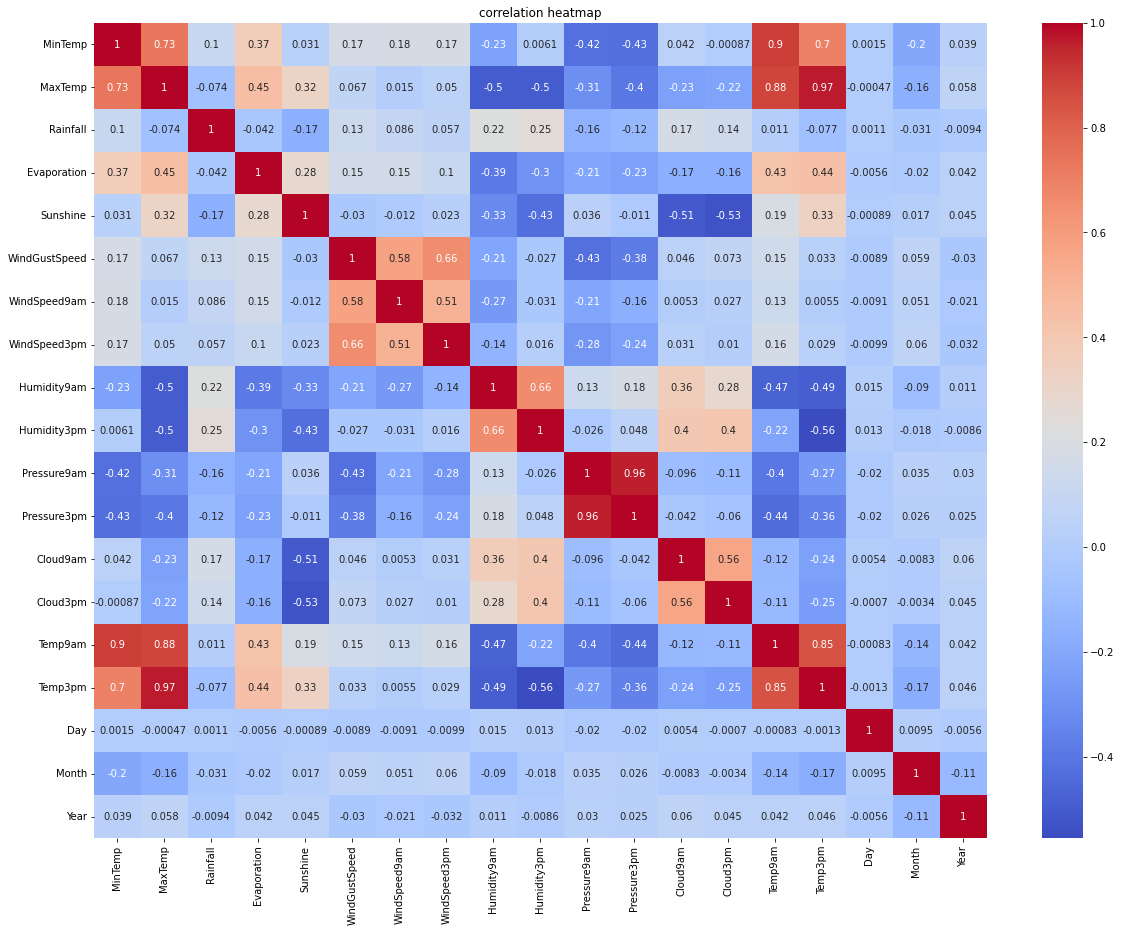

In [49]:
#see relationships between variables 
#check for multi-collinearity
correlation_matrix = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('correlation heatmap')
plt.show()

We can see that there is a highly positive correlation between these pairs of variables: (MaxTemp and MinTemp), (Pressure9am and Pressure3pm), (Temp9am and Temp3pm), (MaxTemp and Temp3pm) , (MaxTemp and Temp9am), (MinTemp and Temp3pm) , and (MinTemp and Temp9am).

#### Outlier Detection and Handling

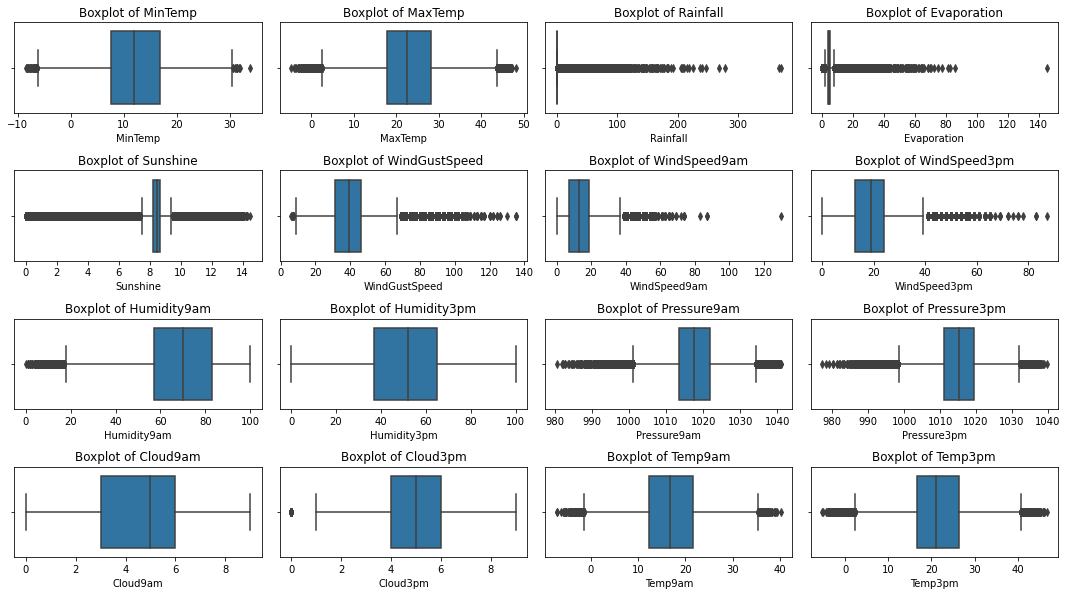

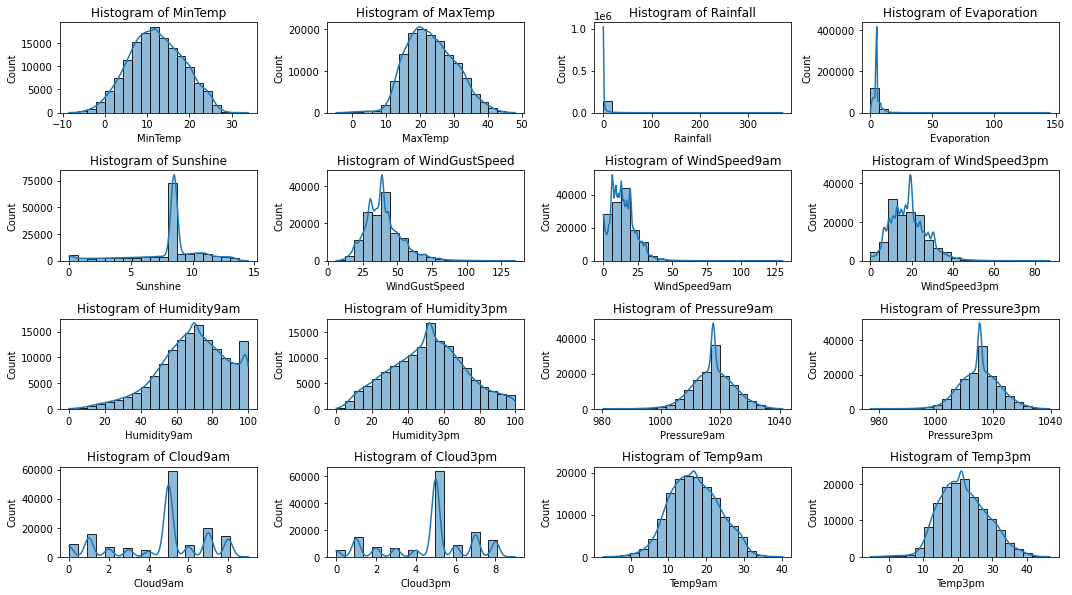

In [50]:
# List of numerical columns
numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm']

# Plot box plots for each numerical feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

# Plot histograms for each numerical feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    # plt.hist(df[column], bins=20, edgecolor='black')
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

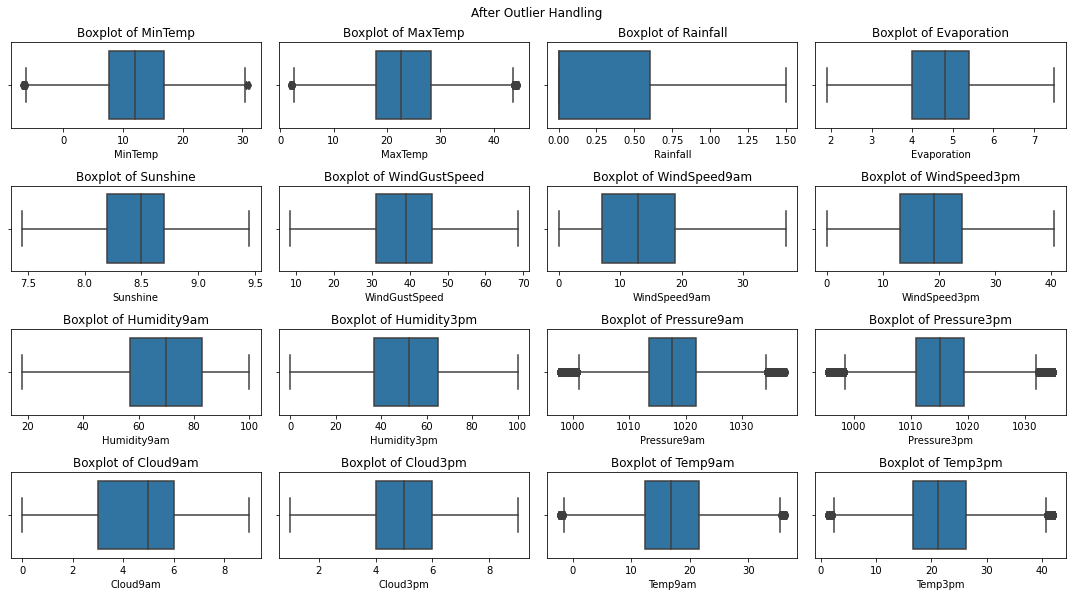

In [51]:
#variables with approximately normal distributions
normal_variables = ['MinTemp', 'MaxTemp','WindSpeed9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
#variables with skewed distributions
skewed_variables = ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm','Humidity9am','Cloud3pm'] 

# Apply Z-score method to handle outliers
for variable in normal_variables:
    z_scores = zscore(df[variable])
    z_score_threshold = 3
    std_multiplier = 2
    left_outliers = z_scores < -z_score_threshold 
    right_outliers = z_scores > z_score_threshold 
    lower_limit = df[variable].mean() - std_multiplier * df[variable].std()
    upper_limit = df[variable].mean() + std_multiplier * df[variable].std()
    # Replace left outliers with a lower limit and right outliers with an upper limit
    df[variable] = np.where(left_outliers, lower_limit, np.where(right_outliers, upper_limit, df[variable]))
   
   
# Apply IQR method to handle outliers
for variable in skewed_variables:
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    upper_threshold = Q3 + 1.5 * IQR
    lower_threshold = Q1 - 1.5 * IQR
    df[variable] = np.where(df[variable] > upper_threshold, upper_threshold, df[variable])
    df[variable] = np.where(df[variable] < lower_threshold, lower_threshold, df[variable])


plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.suptitle('After Outlier Handling')
plt.tight_layout()
plt.show() 


#### Labeled Encoding of Categorical Variables

In [52]:
# Change values in 'RainTomorrow' from a categorical one to a binary one
df['RainTomorrow'] = df['RainTomorrow'].replace({'No': 0, 'Yes': 1})

# Apply one-hot encoding to the remaining categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True) #df_encoded

df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes
0,13.4,22.9,0.6,4.8,8.5,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,1,0,0
1,7.4,25.1,0.0,4.8,8.5,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,0,1,0
2,12.9,25.7,0.0,4.8,8.5,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,0,1,0
3,9.2,28.0,0.0,4.8,8.5,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,4.8,8.5,41.0,7.0,20.0,82.0,33.0,...,1,0,0,0,0,0,0,0,0,0


In [53]:
#export the preprocessed data to a CSV file
df.to_csv("Preprocessed_Data.csv", index=False)

#### Features and Target variable 

In [54]:
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']

#### Train-Test Split

In [55]:
#Splitting the Dataset for Training and Testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X shape: (142193, 113), y shape: (142193,)
X_train shape: (113754, 113), y_train shape: (113754,)
X_test shape: (28439, 113), y_test shape: (28439,)


#### Class Balancing

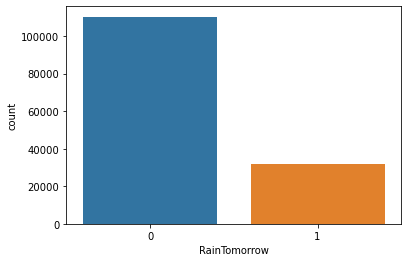

Class Distribution:
   Counts  Percentage
0  110316   77.581878
1   31877   22.418122


In [56]:
#distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='RainTomorrow', data=df)
plt.show()
value_counts = df['RainTomorrow'].value_counts()
percentage_counts = df['RainTomorrow'].value_counts(normalize=True) * 100
print("Class Distribution:")
print(pd.DataFrame({'Counts': value_counts, 'Percentage': percentage_counts}))

We notice a class imbalance with a ratio of about 77:22 between '0' and '1', which can be addressed by oversampling the minority class or undersampling the majority class.

In [57]:
#Apply oversampling to the minority class using Synthetic Minority Over-sampling Technique (SMOTE)

print("Before oversampling:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print("y_train",Counter(y_train))

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("\nAfter oversampling:")
print(f"X_resampled shape: {X_train.shape}, y_resampled shape: {y_train.shape}")
print("y_resampled",Counter(y_train))

Before oversampling:
X_train shape: (113754, 113), y_train shape: (113754,)
y_train Counter({0: 88218, 1: 25536})

After oversampling:
X_resampled shape: (176436, 113), y_resampled shape: (176436,)
y_resampled Counter({0: 88218, 1: 88218})


#### Feature Scaling

In [58]:
# Feature Scaling

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(data=X_train_scaled,columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_scaled,columns=X_test.columns)

X_train_scaled.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes
count,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,...,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000,176436.000000
mean,0.510411,0.482858,0.347667,0.495672,0.444230,0.546782,0.387633,0.469449,0.660060,0.575066,...,0.042480,0.046515,0.076441,0.044163,0.038734,0.043750,0.049106,0.042695,0.045291,0.251502
std,0.165436,0.164048,0.428692,0.278663,0.325421,0.212592,0.228852,0.212010,0.222870,0.214742,...,0.201682,0.210599,0.265704,0.205458,0.192960,0.204538,0.216089,0.202170,0.207943,0.433878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.391609,0.359155,0.000000,0.342424,0.083935,0.398903,0.209409,0.320988,0.524390,0.430000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.501214,0.464789,0.014111,0.517857,0.525000,0.508333,0.351351,0.469136,0.670732,0.580000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.630982,0.598592,0.927807,0.562963,0.525000,0.691667,0.540541,0.592593,0.839506,0.730000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


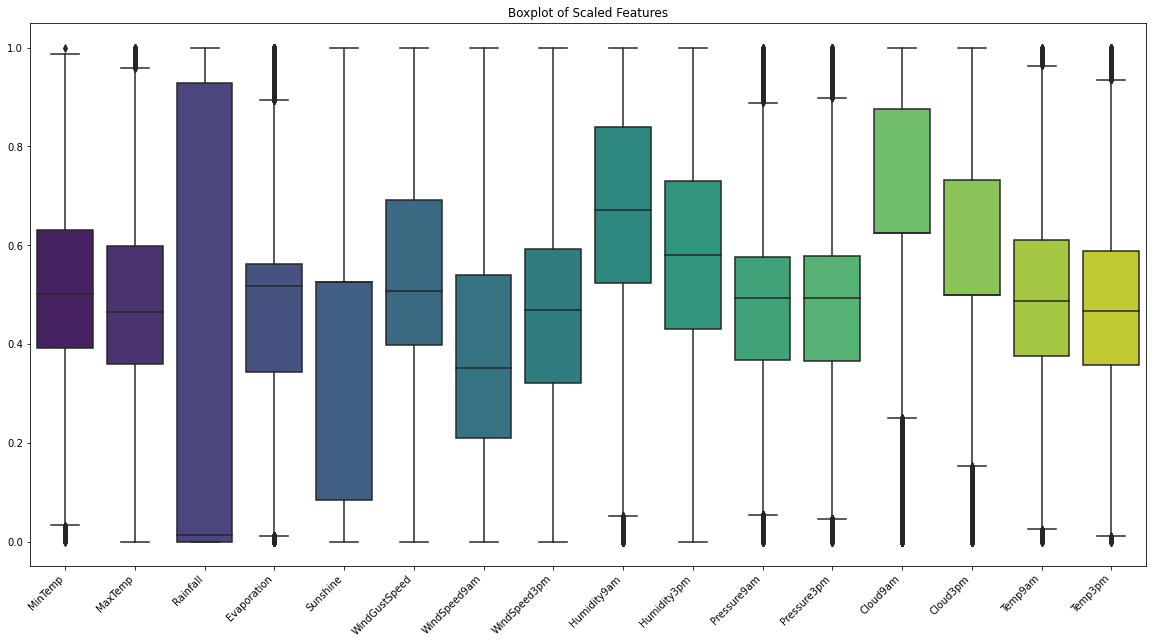

In [59]:
numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                     'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                     'Temp9am', 'Temp3pm']
plt.figure(figsize=(20, 10))
sns.boxplot(data=X_train_scaled[numerical_columns], palette='viridis')
plt.xticks(rotation=45, ha='right')  
plt.title('Boxplot of Scaled Features')
plt.show()                     

## Logistic Regression Model

In [62]:
#Hyperparameter Tuning using Random Search
param_dist = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
              'max_iter': [100, 500, 1000]}

random_search = RandomizedSearchCV(LogisticRegression(random_state=42), param_dist, cv=5, n_iter=10,random_state=42)
random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print(best_params)

{'solver': 'lbfgs', 'max_iter': 1000, 'C': 1}


Training Accuracy: 0.8878516855970436
Testing Accuracy: 0.8326242132283133
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89     22098
           1       0.65      0.55      0.59      6341

    accuracy                           0.83     28439
   macro avg       0.76      0.73      0.74     28439
weighted avg       0.82      0.83      0.83     28439



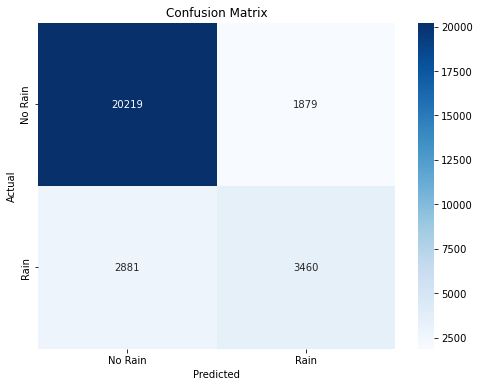

In [63]:
# Model Training
model = LogisticRegression(C=1, solver='lbfgs',max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Model Evaluation
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

conf_matrix = confusion_matrix(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print("Classification Report:\n", classification_rep)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We observe high and comparable values for both training and test sets, indicating a well-performing model that generalizes effectively to new data, minimizing concerns of overfitting.

The model achieved an accuracy of approximately 88.8% on the training set, showing that it learned well from the training data, and accuracy of around 83.3% on the test set, suggesting that the model generalizes well to unseen data.

The model has high precision (88%) and recall (91%) for class 0, indicating that it correctly identifies instances of "No Rain" and rarely misclassifies them. The precision (65%) and recall (55%) for the class 1 are lower, suggesting that the model is less accurate in identifying instances of "Rain" and misses some positive cases.

The weighted average F1-score is around 0.83, reflecting a balanced performance across classes.